In [43]:
ls

__pycache__/  sample_data/  tic_env.py


In [76]:
def whose_grid(g, player):
    '''
    g is a grid matrix of 3 x 3
    player : X for me, O for oppenent
    '''
    if player == 'X':
        color = 1
    else:
        color = -1

    res = torch.zeros(g.shape)
    for x in range(g.shape[0]):
        for y in range(g.shape[1]):
            if g[x][y] == color:
                res[x][y] = color
            else:
                res[x][y] = 0

    return res
    

In [79]:
def a_to_pos(a):
    '''
    a : int [0,8]
    '''
    if a < 3:
        return (0,a)
    elif a < 6:
        return (1, a-3)
    else:
        return (2, a-6)

In [180]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer

# Hyper Parameters
BATCH_SIZE = 64
LR = 5e-4                  # learning rate
# EPSILON = 0.9               # greedy policy
GAMMA = 0.99                 # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MEMORY_CAPACITY = 10000
N_ACTIONS = 9
N_STATES = 9 * 2
# ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape


class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(N_STATES, 128)
        self.layer2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, N_ACTIONS)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.out(x)
        # actions_value = F.softmax(x, dim=1)
        return x


class DQN(object):
    def __init__(self, epsilon=0.9, player='X'):
        self.eval_net, self.target_net = Net(), Net()
        self.epsilon = epsilon
        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = torch.zeros((MEMORY_CAPACITY, N_STATES*2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()
        self.player = player
        self.loss = []

    def act(self, x):
        # x = torch.unsqueeze(torch.FloatTensor(x), 0)
        x = x.view(1, -1)
        # input only one sample
        if np.random.uniform() < self.epsilon:   # greedy
            actions_value = self.eval_net.forward(x)
            # print("actions_value")
            # print(actions_value)
            action = int(actions_value.argmax())
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
        return action

    def store_transition(self, s, a, r, s_):
        s = s.view(1, -1)
        s_ = s_.view(1, -1)
        a_r = torch.Tensor([a, r]).view(1, -1)
        transition = torch.hstack((s, a_r, s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1
        # print("mm :" + str(self.))

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        # print("mm")
        # print(self.memory[-1,:])
        b_s = torch.Tensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].long())
        b_r = torch.Tensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.Tensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        # print(q_eval)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)
        # print("loss :" + str(loss))
        self.loss.append(loss.item())
        

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

## For text

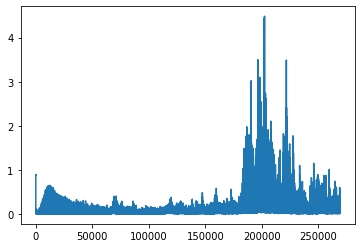

In [173]:
dqn = DQN()
env = TictactoeEnv()

print('\nCollecting experience...')
for i_game in range(10000):
    ## reset game
    grid, end, winner = env.reset()
    
    s_t = torch.zeros((2, 3, 3))
    ep_r = 0
    while True:
        # Show chess board
        # env.render()

        # Update state
        a = dqn.act(s_t)
        
        # Dectect avaliablity
        pos_x, pos_y = a_to_pos(a)
        grid, _, _ = env.observe()
        if grid[pos_x][pos_y] != 0:
            r = -1
            ep_r += r
            dqn.store_transition(s_t, a, r, s_next)
            if dqn.memory_counter > MEMORY_CAPACITY:
                dqn.learn()
            continue

        # print(pos_x, pos_y)

        # take action
        grid_next, end, winner = env.step(a)
        grid_mine = whose_grid(grid_next, 'X')
        grid_opp = whose_grid(grid_next, 'O')
        s_next = torch.stack((grid_mine, grid_opp), axis=0)

        # update the reward
        r1 = env.reward(player='X')
        r2 = env.reward(player='O')
        r = r1 + r2

        dqn.store_transition(s_t, a, r, s_next)

        ep_r += r
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
            # if end:
            #     print('Ep: ', i_game,
            #           '| Ep_r: ', round(ep_r, 2))

        if end:
            # print('Ep: ', i_game,'| Ep_r: ', ep_r)
            break
        s_t = s_next

x = np.arange(0, len(dqn.loss))
y = dqn.loss
plt.plot(x, y)

## Question 11

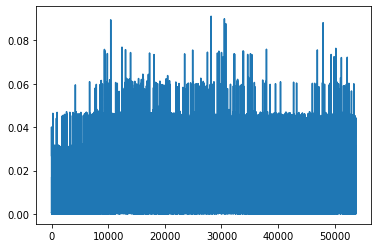

In [183]:
env = TictactoeEnv()

Turns = np.array(['X','O'])
player_opt_1 = DQN(epsilon=0.9, player=Turns[0])
for i in range(20000):
    env.reset()
    grid, _, __ = env.observe()
    # initialize state
    s_t = torch.zeros((2, 3, 3))
    # Turns = Turns[np.random.permutation(2)]
    # player_opt_1 = DQN(epsilon=0., player=Turns[0])
    player_opt_2 = OptimalPlayer(epsilon=0.5, player=Turns[1])
    ep_r = 0
    for j in range(9):
        if env.current_player == player_opt_1.player:
            move = player_opt_1.act(s_t)
            # dectect if this move is available
            pos_x, pos_y = a_to_pos(move)
            grid, _, _ = env.observe()
            if grid[pos_x][pos_y] != 0:
                r = -1
                winner = Turns[1]
                # ep_r += r
                # s_next = s_t
                # player_opt_1.store_transition(s_t, move, r, s_next)
                # if player_opt_1.memory_counter > MEMORY_CAPACITY:
                #     player_opt_1.learn()
                # continue

                # print('-------------------------------------------')
                # print("ep_r:  " + str(ep_r))
                # print('Game end, winner is player ' + str(winner))
                # print('Optimal player 1 = ' +  Turns[0])
                # print('Optimal player 2 = ' +  Turns[1])
                # env.render()
                env.reset()
                break

        else:
            move = player_opt_2.act(grid)
            a_x, a_y = move
            move = int(a_x) * 3 + int(a_y)

        # Move
        grid, end, winner = env.step(move, print_grid=False)
        grid_mine = whose_grid(grid_next, Turns[0])
        grid_opp = whose_grid(grid_next, Turns[1])
        s_next = torch.stack((grid_mine, grid_opp), axis=0)


        # update the reward
        r1 = env.reward(player=Turns[0])
        # r2 = env.reward(player=Turns[1])
        # r = r1 + r2
        r = r1

        # print("move:")
        # print(move)
        player_opt_1.store_transition(s_t, move, r, s_next)

        # ep_r += r
        if player_opt_1.memory_counter > MEMORY_CAPACITY:
            player_opt_1.learn()

        if end:
            
            # print('-------------------------------------------')
            # print("ep_r:  " + str(ep_r))
            # print('Game end, winner is player ' + str(winner))
            # print('Optimal player 1 = ' +  Turns[0])
            # print('Optimal player 2 = ' +  Turns[1])
            # env.render()
            env.reset()
            break
        
        s_t = s_next

import matplotlib.pyplot as plt 
x = np.arange(0, len(player_opt_1.loss))
y = player_opt_1.loss
plt.plot(x, y)